# **Marine Heatwaves in the Rockall Trough**

The data was downloaded from https://scotmarphys.github.io/ScotMarPhys.OSNAP-Mooring-Processing.io/. And the algorithm for working with marine heatwaves by Hobday et al. (2016) was downloaded here: https://github.com/ecjoliver/marineHeatWaves.

## Read in packages for this script

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date

In [2]:
import warnings
warnings.filterwarnings("ignore")

## **Data and Definintions**

## Dataset

The depth variable was turned into a coordinate and the dataset was reduced to contain only the temperature data we are interested in. The temperature data was converted from K into °C to make it easier to understand. 

In [3]:
file_name = "data/Rockall-Trough-Mooring-Time-Series-2020.nc"
ds = xr.open_dataset(file_name)

# making DEPTH a coordinate -› allows for calling specific depths (instead of the awkwared 20db grid the ds had before)
ds.coords['DEPTH'] = ds.PRES

# overwrite dataset and select only the variables of interst (temperature data)
ds = ds[['TG_EAST', 'TG_WEST']]

In [4]:
# creating two new variables in the ds that have the unit °C for temperature instead of K

# for TG_EAST
ds['TG_EAST_C'] = ds.TG_EAST-273.15
ds.TG_EAST_C.attrs = ds.TG_EAST.attrs 
ds.TG_EAST_C.attrs['units'] = 'degC'
ds.TG_EAST_C.attrs

# and TG_WEST
ds['TG_WEST_C'] = ds.TG_WEST-273.15
ds.TG_WEST_C.attrs = ds.TG_WEST.attrs 
ds.TG_WEST_C.attrs['units'] = 'degC'
ds.TG_WEST_C.attrs;

## Resampling the dataset

Before continuing the dataset needs to be resampled to fit the algorithm. By reducing the resolution to 1 day (1D) instead of half days(12 hour periods) the algorithm can work with the data input. When resampling the dataset I made sure that the ds attributes did not get lost.

In [5]:
# resampling the dataset -› so that we have full days instead of half days -› by calculating the mean

ds1D = ds.resample(TIME = "1D").mean();

In [6]:
# making sure that the new 1D data set has the same attributes as the original ds

ds1D.attrs = ds.attrs

## Depth that instruments are located on the moorings

In [7]:
depth_E = [100, 250, 500, 750, 1000, 1250, 1500, 1760]
depth_W = [100, 250, 500, 750, 1000, 1250, 1500, 1575]


## A contour plot of the temperature data

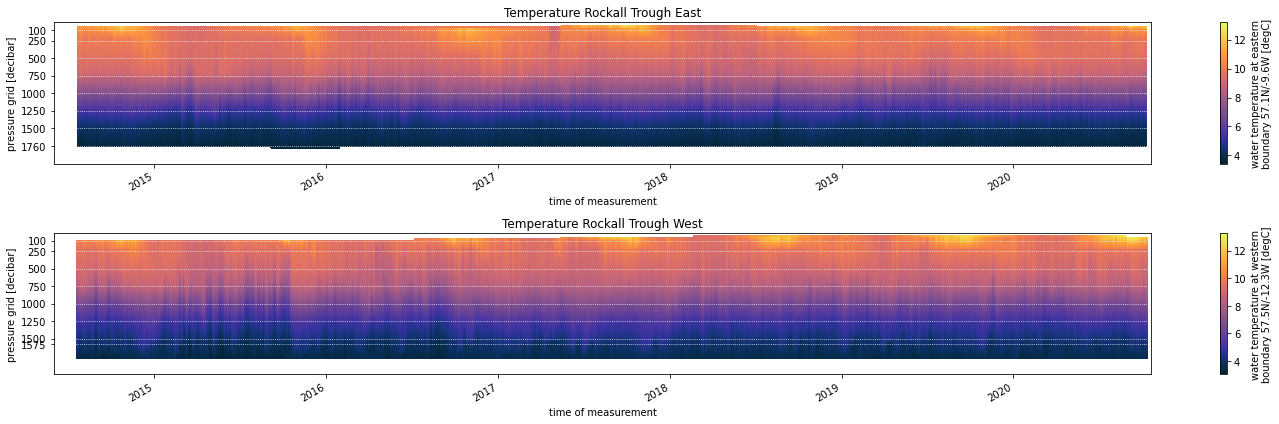

In [59]:
# notes: 
# yincrease = False -› inverts the y-axis, setting ylim = (high, low) does the same (but limets need to be known)
# plot.contourf() creates a plot with more clearly defined contours

fig, ax = plt.subplots(2, 1, figsize = (20, 6))

ds.TG_EAST_C.plot(ax=ax[0], x = 'TIME', y = 'DEPTH', yincrease = False, cmap = cm.cm.thermal, yticks = depth_E);
ax[0].set_title("Temperature Rockall Trough East");
ax[0].yaxis.grid(linestyle =':', color = 'w')

ds.TG_WEST_C.plot(ax=ax[1], x = 'TIME', yincrease = False, cmap = cm.cm.thermal, yticks = depth_W);
ax[1].set_title("Temperature Rockall Trough West");
ax[1].yaxis.grid(linestyle =':', color = 'w')

fig.tight_layout();

#plt.savefig('Temperature overview Rockall Trough East and West', dpi = 300, bbox_inches='tight')

## Creating line plots to compare temperature at the surface and bottom EAST and WEST

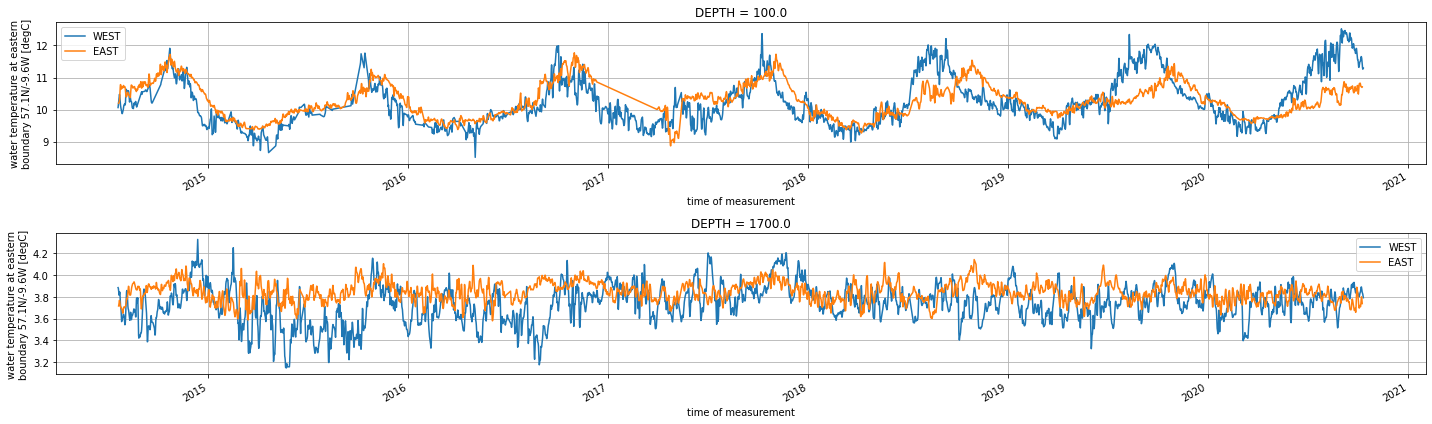

In [9]:
# extracting one temperature profile by slicing the dataset at a specific depth
# creating 4 plots that show the temperature at 100m and 1700m from the eastern and western boundary

fig, ax = plt.subplots(2, 1, figsize = (20, 6))

ds.TG_WEST_C.sel(DEPTH = 100).plot(ax=ax[0], label = 'WEST');
ds.TG_WEST_C.sel(DEPTH = 1700).plot(ax=ax[1], label = 'WEST');

ds.TG_EAST_C.sel(DEPTH = 100).plot(ax=ax[0], label = 'EAST');
ds.TG_EAST_C.sel(DEPTH = 1700).plot(ax=ax[1], label = 'EAST');

for axs in ax: 
    axs.legend()
    axs.grid()
#ax[1].legend()

fig.tight_layout();

# **Functions (and Working with the algorithm)** MHWs

## **Functions** 

### MHW_func definines the variables that go into the algorithm and then gives out algorithm varaibles

The function below defines the varibles I want I can use an iteration to get all my datapoints for all desired depth (the ones that actually have an instrument and are not intrapolated) and save the output to a dictionary.

In [10]:
# creating a function so I can iterate through all depths later

def MHW_func (data, depth):
    yy_start = int(data.TIME[0].dt.year)
    yy_end = int(data.TIME[-1].dt.year)
    mm_start = int(ds1D.TG_EAST.TIME[0].dt.month)
    mm_end = int(ds1D.TG_EAST.TIME[-1].dt.month)
    dd_start = int(ds1D.TG_EAST.TIME[0].dt.day)
    dd_end = int(ds1D.TG_EAST.TIME[-1].dt.day)
    
    t = np.arange(
        date(yy_start, mm_start, dd_start).toordinal(),                 # .toordinal turns the date into a number that the algorithm can process
        date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.sel(DEPTH=depth, method = 'nearest').squeeze().values   # by using .squeeze().values we are first removing any other depth and then turning the data into a 1d numpy array 
                                                                        # without doing this the data will still be in an array and the algorithm can't handle it
    
    mhws, clim = mhw.detect(t, temp)                                    # using the algorithm
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True)            # cold spells 
    return mhws, mcss, clim, clim_cold, t, temp  

In [11]:
mhws, mcss, clim, clim_cold, t, temp = MHW_func (ds1D.TG_EAST_C, 100)

print(mcss['n_events'])

19


### MHW_details gives out some key details for the chosen MHW

In [12]:
def MHW_details(mhws,i):
    i = i-1
    print('Number of MHWs:', mhws['n_events'])
    print('MHW number:', i+1)
    print('Start Date:', mhws['date_start'][i])
    print('End Date:', mhws['date_end'][i])
    print('Duration:', mhws['duration'][i], 'days')
    print('Max intensity relative to clim:', '%.3f' % mhws['intensity_max'][i])
    print('Max intensity relative to thresh:', '%.3f' % mhws['intensity_max_relThresh'][i])
    print('Max absolute temp:', '%.5f' % mhws['intensity_max_abs'][i])
    print('———————')

### MHW_plot

In [13]:
def MHW_plot(t,temp,clim):

    fig, ax = plt.subplots(figsize= (15,5))
    plt.plot(t,temp,label='temp', color='grey', linewidth='.75')
    plt.plot(t,clim['seas'],label='clim', color='b')
    plt.plot(t,clim['thresh'], label='thresh', color='r')
    #plt.plot(ds1D.TIME,clim_cold['thresh'], label='thresh')
    plt.legend()

    yloc = YearLocator()
    mloc = MonthLocator()
    ax.xaxis.set_major_locator(yloc)
    ax.xaxis.set_minor_locator(mloc)

    plt.grid()

### MHW_stats

In [14]:
def MHW_stats(t, mhws, title=False, title_str=None):
    mhwBlock = mhw.blockAverage(t, mhws)

    fig, ax = plt.subplots(1,2, figsize=(14,4), sharex = True)
    plt.subplot(1,2,1)
    plt.plot(mhwBlock['years_centre'], mhwBlock['count'], '-o')
    plt.ylim(0,9)
    plt.ylabel('[count]')
    plt.title('Number of MHWs by year')


    plt.subplot(1,2,2)
    plt.plot(mhwBlock['years_centre'], mhwBlock['intensity_max'], '-o')
    plt.ylabel(r'[$^\circ$C]')
    plt.xlim(mhwBlock['years_centre'][0]-.5 ,mhwBlock['years_centre'][-1]+.5)
    plt.title('Average MHW maximum intensity by year')
    
    #ax[1].set_xlim(ax[0].get_xlim())
    fig.tight_layout
    
    if title:
        fig.suptitle(title_str)
    

# **Calculations and Plotting**

## **Iteration:** creates dictionary with output for east and west

In [69]:
## EAST MHW

# define 4 empty dictionaries
mhws_all_E,mcss_all_E,clim_all_E,clim_cold_all_E,t_all_E,temp_all_E = {},{},{},{},{},{}

# Iterating through all instrument depths
for n in depth_E:
    mhws, mcss, clim, clim_cold, t, temp = MHW_func(ds1D.TG_EAST_C, n)
    mhws_all_E.update({str(n):mhws})
    mcss_all_E.update({str(n):mcss})
    clim_all_E.update({str(n):clim})
    clim_cold_all_E.update({str(n):clim_cold})
    t_all_E.update({str(n):t})
    temp_all_E.update({str(n):temp})

In [70]:
## WEST MHW

# define 4 empty dictionaries
mhws_all_W,mcss_all_W,clim_all_W,clim_cold_all_W,t_all_W,temp_all_W = {},{},{},{},{},{}

# Iterating through all instrument depths
for n in depth_W:
    mhws, mcss, clim, clim_cold, t, temp = MHW_func(ds1D.TG_WEST_C, n)
    mhws_all_W.update({str(n):mhws})
    mcss_all_W.update({str(n):mcss})
    clim_all_W.update({str(n):clim})
    clim_cold_all_W.update({str(n):clim_cold})
    t_all_W.update({str(n):t})
    temp_all_W.update({str(n):temp})

## Create Plots

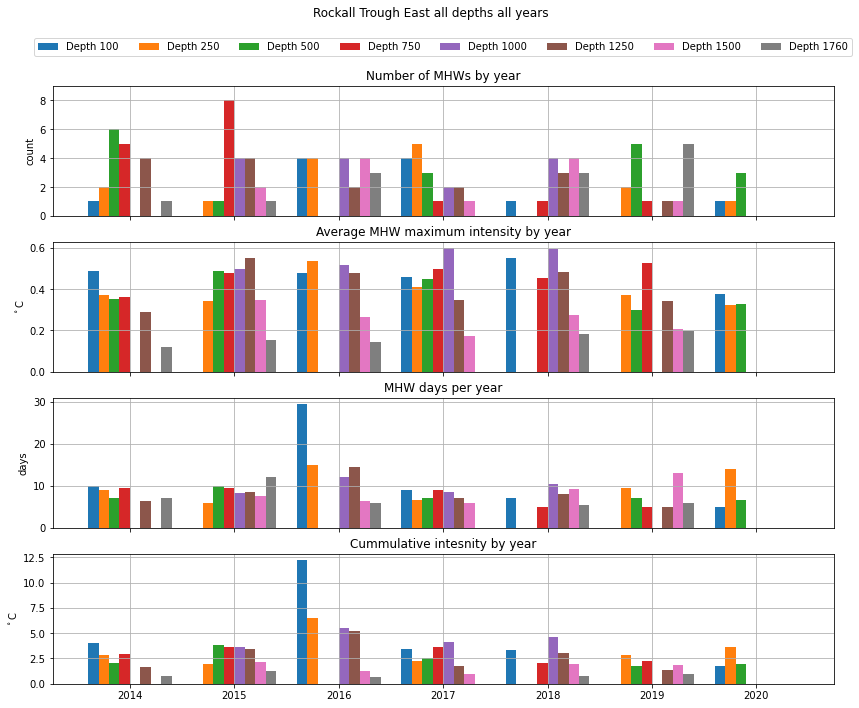

In [26]:
# create stats plots that plot all depths in one
#colormap = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, axs = plt.subplots(4,1, figsize=(14,11), sharex = True)
fig.suptitle('Rockall Trough East all depths all years')
width=0.1 
dt = np.arange(-0.35,0.36,width)  
for i,n in enumerate(depth_E):
    mhws, t= mhws_all_E[str(n)], t_all_E[str(n)]
    mhwBlock = mhw.blockAverage(t, mhws)
    
    axs[0].bar(mhwBlock['years_centre']+dt[i], mhwBlock['count'], width, label = 'Depth '+ str(n))
    axs[1].bar(mhwBlock['years_centre']+dt[i], mhwBlock['intensity_max'], width, label = 'Depth '+ str(n))
    axs[2].bar(mhwBlock['years_centre']+dt[i], mhwBlock['duration'], width, label = 'Depth '+ str(n))
    axs[3].bar(mhwBlock['years_centre']+dt[i], mhwBlock['intensity_cumulative'], width, label = 'Depth '+ str(n))
    #print(mhwBlock['years_centre'][0]+dt[i])
    
axs[0].set_ylim(0,9)
axs[0].set_ylabel('count')
axs[0].set_title('Number of MHWs by year')
axs[0].legend(loc='center', bbox_to_anchor=(.5, 1.3), ncol = 8)
    
axs[1].set_ylabel(r'$^\circ$C')
axs[1].set_title('Average MHW maximum intensity by year')

axs[2].set_ylabel('days')
axs[2].set_title('MHW days per year')

axs[3].set_ylabel(r'$^\circ$C')
axs[3].set_title('Cummulative intesnity by year')

for i in axs:
    i.grid()

fig.tight_layout;
#fig.legend(bbox_to_anchor=(0, .5))
#plt.savefig('stats_plots_EAST/TG_EAST_C_all', dpi = 300)

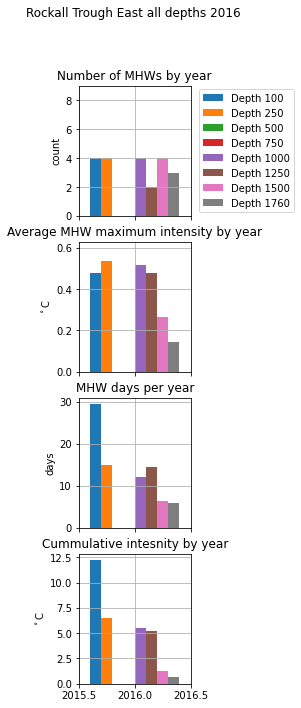

In [58]:
# create stats plots that plot all depths in one 2016
#colormap = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, axs = plt.subplots(4,1, figsize=(2,11), sharex = True)
fig.suptitle('Rockall Trough East all depths 2016')
width=0.1
dt = np.arange(-0.35,0.36,width)  
for i,n in enumerate(depth_E):
    mhws, t= mhws_all_E[str(n)], t_all_E[str(n)]
    mhwBlock = mhw.blockAverage(t, mhws)
    
    axs[0].bar(mhwBlock['years_centre']+dt[i], mhwBlock['count'], width, label = 'Depth '+ str(n))
    axs[1].bar(mhwBlock['years_centre']+dt[i], mhwBlock['intensity_max'], width, label = 'Depth '+ str(n))
    axs[2].bar(mhwBlock['years_centre']+dt[i], mhwBlock['duration'], width, label = 'Depth '+ str(n))
    axs[3].bar(mhwBlock['years_centre']+dt[i], mhwBlock['intensity_cumulative'], width, label = 'Depth '+ str(n))
    #print(mhwBlock['years_centre'][0]+dt[i])
    
axs[0].set_ylim(0,9)
axs[0].set_xlim(2015.5, 2016.5)
axs[0].set_ylabel('count')
axs[0].set_title('Number of MHWs by year')
axs[0].legend(loc='center', bbox_to_anchor=(1.5, .5), ncol = 1)
    
axs[1].set_ylabel(r'$^\circ$C')
axs[1].set_title('Average MHW maximum intensity by year')

axs[2].set_ylabel('days')
axs[2].set_title('MHW days per year')

axs[3].set_ylabel(r'$^\circ$C')
axs[3].set_title('Cummulative intesnity by year')

for i in axs:
    i.grid()

fig.tight_layout;
#fig.legend(bbox_to_anchor=(0, .5))
#plt.savefig('stats_plots_EAST/TG_EAST_C_2016', dpi = 300, bbox_inches='tight')

In [ ]:
# create stats plots EAST

for n in depth_E:
    mhws, t = mhws_all_E[str(n)], t_all_E[str(n)]
    MHW_stats(t, mhws,  title = True, title_str='Rockall Trough East Depth ' + str(n))
    
    #plt.savefig('stats_plots_EAST/TG_EAST_C' + str(n), dpi = 300)

In [ ]:
# create figures WEST
for n in depth_W:
    temp=temp_all_W[str(n)]
    clim=clim_all_W[str(n)]
    MHW_plot(ds1D.TIME,temp,clim)
    plt.title('Rockall Trough West Depth ' + str(n))
    #plt.savefig('figures_WEST/TG_WEST_C' + str(n), dpi = 300)

In [ ]:
# create figures EAST
for n in depth_E:
    temp=temp_all_E[str(n)]
    clim=clim_all_E[str(n)]
    MHW_plot(ds1D.TIME,temp,clim)
    plt.title('Rockall Trough EAST Depth ' + str(n))
    #plt.savefig('figures_EAST/TG_EAST_C' + str(n), dpi = 300)

In [ ]:
MHW_plot(ds1D.TIME,temp,clim_cold)

In [72]:
## Iterate through dictionary by depth (name) and print dtails

#for n in depth_E:
#    print (n)
#    MHW_details(mhws_all_E[str(n)],1)
    
    
for n in np.arange(1,10):
    MHW_details(mhws_all_E['100'],n)


Number of MHWs: 11
MHW number: 1
Start Date: 2014-07-24
End Date: 2014-08-02
Duration: 10 days
Max intensity relative to clim: 0.489
Max intensity relative to thresh: 0.226
Max absolute temp: 10.75900
———————
Number of MHWs: 11
MHW number: 2
Start Date: 2016-09-02
End Date: 2016-09-10
Duration: 9 days
Max intensity relative to clim: 0.479
Max intensity relative to thresh: 0.213
Max absolute temp: 11.06186
———————
Number of MHWs: 11
MHW number: 3
Start Date: 2016-10-09
End Date: 2016-10-16
Duration: 8 days
Max intensity relative to clim: 0.482
Max intensity relative to thresh: 0.168
Max absolute temp: 11.50992
———————
Number of MHWs: 11
MHW number: 4
Start Date: 2016-11-03
End Date: 2016-11-08
Duration: 6 days
Max intensity relative to clim: 0.473
Max intensity relative to thresh: 0.209
Max absolute temp: 11.66772
———————
Number of MHWs: 11
MHW number: 5
Start Date: 2016-12-21
End Date: 2017-03-25
Duration: 95 days
Max intensity relative to clim: 0.468
Max intensity relative to thresh: 

In [65]:
#mhw.detect?

## **2016** Presentation Figures

In [19]:
# create new climatology to use with 2016, 100m EAST data -› exclude 2017
# first create dataset that excludes 2017 data and any non-full years i.e. 2014 & 2020... 
    # I believe the algortithm would do that anyway ... I can test that

dsNC = ds1D.sel(TIME =~ ((ds1D.TIME.dt.year == 2014)&
                   (ds1D.TIME.dt.year == 2017)&
                   (ds1D.TIME.dt.year == 2020)))

In [60]:
# define t and temp to go into formula
t_alt = np.arange(
        date(2015,1,1).toordinal(),
        date(2018,12,31).toordinal()+1,1)
temp_alt = dsNC.TG_EAST_C.sel(DEPTH=100).squeeze().values 

In [87]:
#mhws_alt, clim_alt = mhw.detect(t_alt,temp_alt)

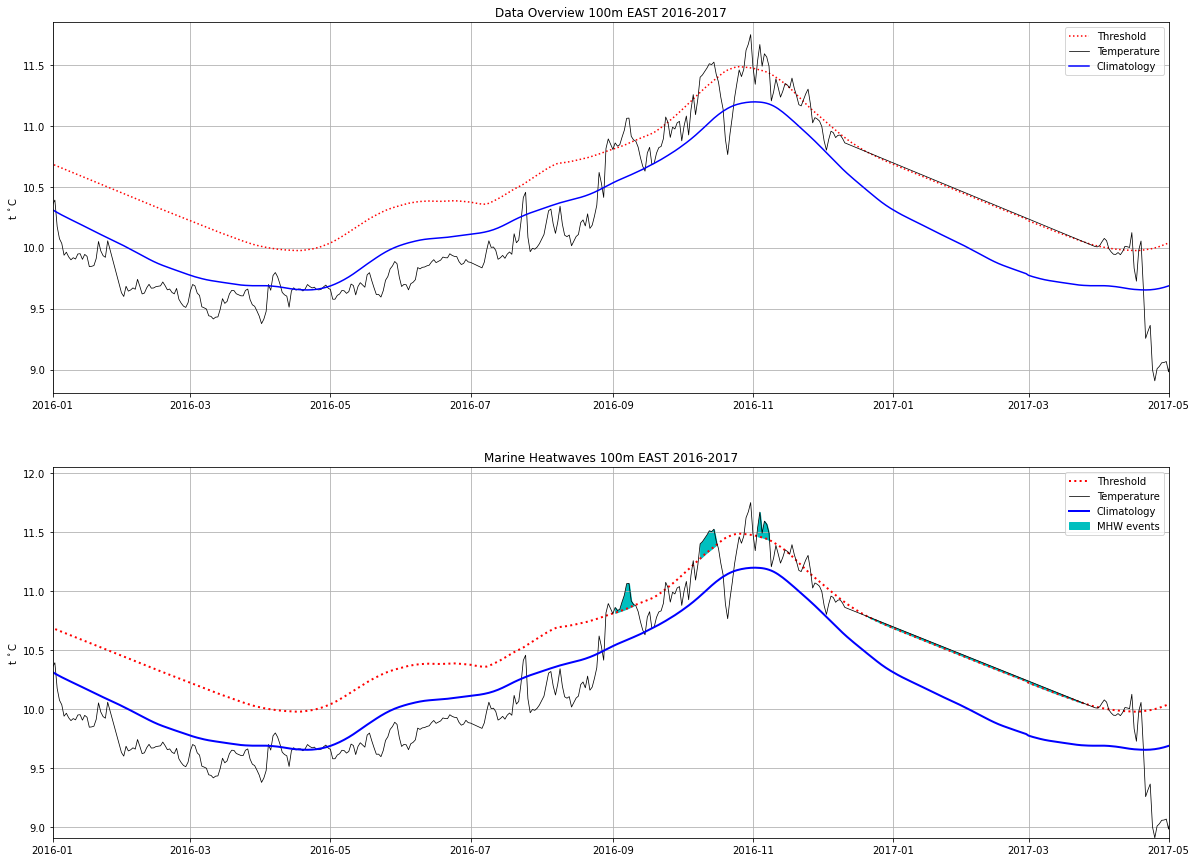

In [86]:
## adapt this to show me the MHWs at 100m depth in 2016 EAST

# temp 2016 100m
mhws = mhws_all_E['100']
t = t_all_E['100']
temp = temp_all_E['100']
clim = clim_all_E['100']

# copy past plot from example
dates = [date.fromordinal(tt.astype(int)) for tt in t]
#dates_mhws = [date.fromordinal(tt.astype(int)) for tt in mhws]
ev = np.argmax(mhws['intensity_max'])
#ev = np.arange(mhws['intensity_max'])

plt.figure(figsize=(20,15))
plt.subplot(2,1,1)

# Plot t, seasonal cycle, and threshold
plt.plot(dates, clim['thresh'], ':r', label = 'Threshold')
plt.plot(dates, temp, 'k', label = 'Temperature', linewidth = .75)
plt.plot(dates, clim['seas'], 'b', label = 'Climatology')
plt.legend()
plt.title('Data Overview 100m EAST 2016-2017')
#plt.xlim(dates[0], dates[-1])
plt.xlim(date(2016,1,1), date(2017,5,1))
plt.ylim(temp.min()-0.1, temp.max()+0.1)
plt.ylabel(r't $^\circ$C')
plt.grid()

plt.subplot(2,1,2)

# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-9, ev+1, 1):
    t1 = np.where(t==mhws['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color='c')

# Find indices for MHW of interest and shade accordingly
t1 = np.where(t==mhws['time_start'][ev])[0][0]
t2 = np.where(t==mhws['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                 color='c', label = 'MHW events')
               
# Plot t, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, clim['thresh'], ':r', linewidth=2, label = 'Threshold')
plt.plot(dates, temp, 'k', linewidth=.75, label = 'Temperature')
plt.plot(dates, clim['seas'], 'b', linewidth=2, label = 'Climatology')
plt.legend()
plt.title('Marine Heatwaves 100m EAST 2016-2017')
plt.xlim(date(2016,1,1), date(2017,5,1))
#plt.xlim(dates[0], dates[-1])
plt.ylim(temp.min(), temp.max()+0.3)
plt.grid()
plt.ylabel(r't $^\circ$C');

plt.savefig('100m_EAST_zoom_2016-2017', dpi = 300)

## Copied plot from example_synthetic.ipynb script and adapted it to run in this script

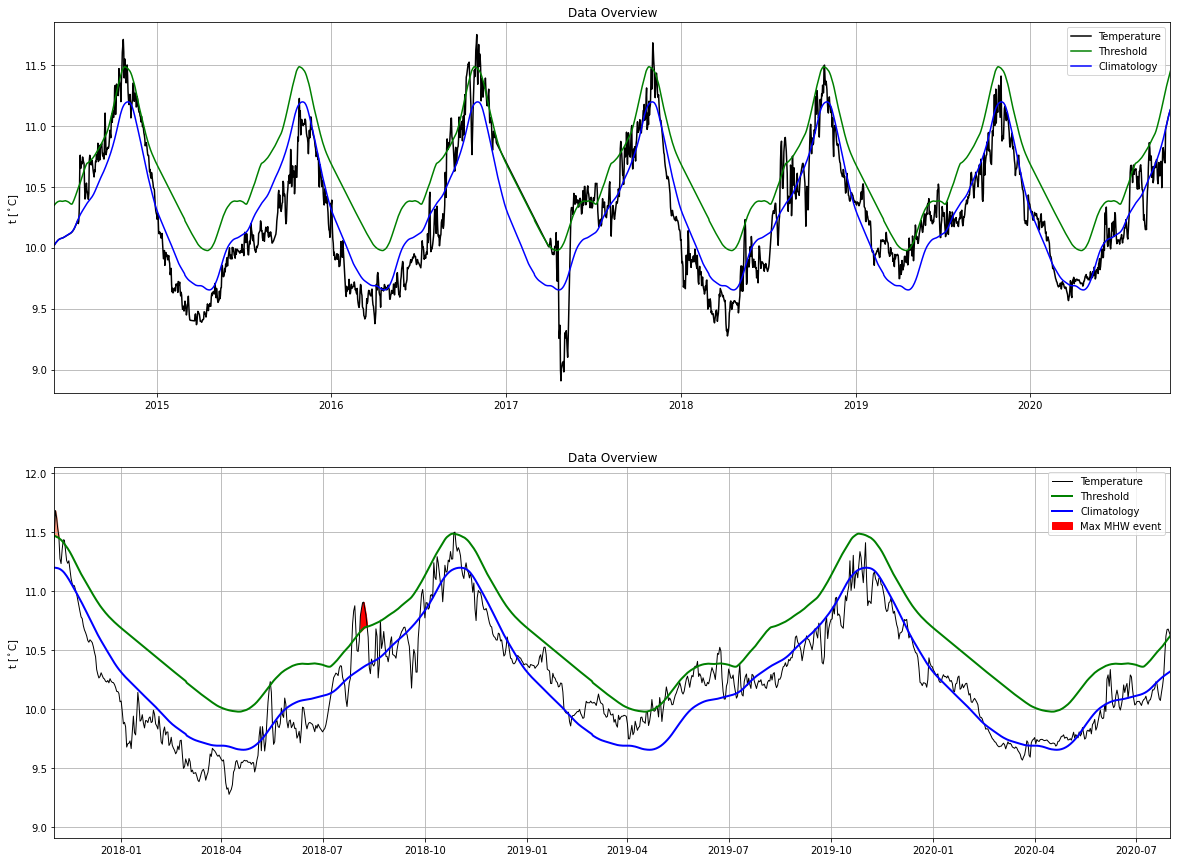

In [92]:
# more or less as taken from example_synthetic.html

# copy past plot from example
dates = [date.fromordinal(tt.astype(int)) for tt in t]
#dates_mhws = [date.fromordinal(tt.astype(int)) for tt in mhws]
ev = np.argmax(mhws['intensity_max'])

plt.figure(figsize=(20,15))
plt.subplot(2,1,1)

# Plot t, seasonal cycle, and threshold
plt.plot(dates, temp, 'k-', label = 'Temperature')
plt.plot(dates, clim['thresh'], 'g-', label = 'Threshold')
plt.plot(dates, clim['seas'], 'b-', label = 'Climatology')
plt.legend()
plt.title('Data Overview')
plt.xlim(dates[0], dates[-1])
plt.ylim(temp.min()-0.1, temp.max()+0.1)
plt.ylabel(r't [$^\circ$C]')
plt.grid()
plt.subplot(2,1,2)

# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-1, ev+1, 1):
    t1 = np.where(t==mhws['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest and shade accordingly
t1 = np.where(t==mhws['time_start'][ev])[0][0]
t2 = np.where(t==mhws['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                 color='r', label = 'Max MHW event')
# Plot t, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, temp, 'k-', linewidth=1, label = 'Temperature')
plt.plot(dates, clim['thresh'], 'g-', linewidth=2, label = 'Threshold')
plt.plot(dates, clim['seas'], 'b-', linewidth=2, label = 'Climatology')
plt.legend()
plt.title('Data Overview')
plt.xlim(mhws['date_start'][ev-1], mhws['date_end'][ev+1])
plt.ylim(temp.min(), temp.max()+0.3)
plt.grid()
plt.ylabel(r't [$^\circ$C]');

## Plotting some stats code also from example_synthetic.ipynb 

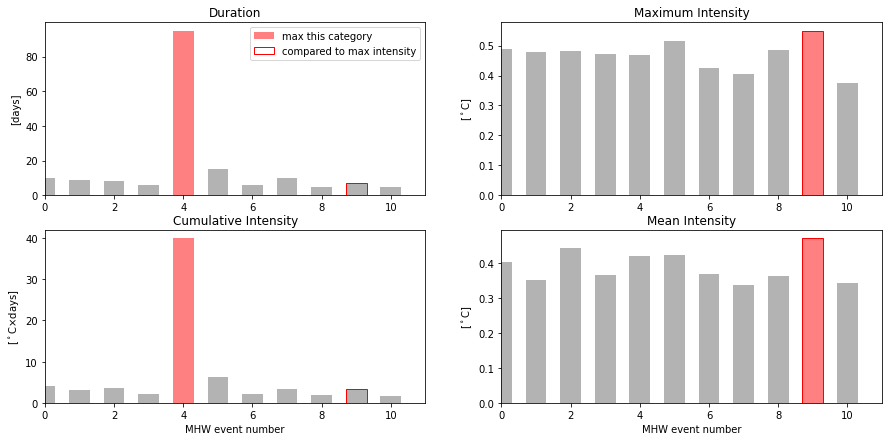

In [90]:
plt.figure(figsize=(15,7))

# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws['duration'])
plt.bar(range(mhws['n_events']), mhws['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['duration'][evMax], width=0.6, color=(1,0.5,0.5), label = 'max this category')
plt.bar(ev, mhws['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none', label = 'compared to max intensity')
plt.xlim(0, mhws['n_events'])
plt.ylabel('[days]')
plt.legend()
plt.title('Duration')

# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws['intensity_max'])
plt.bar(range(mhws['n_events']), mhws['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')

# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws['intensity_mean'])
plt.bar(range(mhws['n_events']), mhws['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')

# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws['intensity_cumulative'])
plt.bar(range(mhws['n_events']), mhws['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number');

## More copied code to create plots

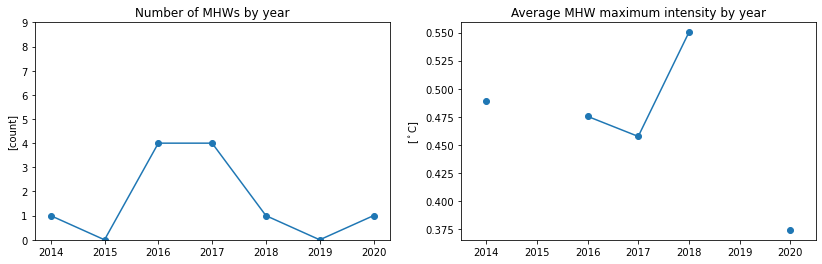

In [93]:
MHW_stats(t, mhws)

In [ ]:
# some stats

mean, trend, dtrend = mhw.meanTrend(mhwBlock)
print("There are on average " + str(mean['count']) + " MHWs in each year, \n \
with a linear trend of " + str(trend['count']) + " MHW events per year \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['count']) > dtrend['count']) + "\n")

print ("The average maximum intensity is " + str(mean['intensity_max']) + " deg. C, \n \
with a linear trend of " + str(trend['intensity_max']) + " deg. C per year \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['intensity_max']) > dtrend['intensity_max']))

# Summary
I am making progress :). By using functions I can make more complex things easier to repeat. 
- learn how to iterate
- understand all outputs of the mhw function
- look at mooring set up (shallowest depth with longterm data seems to be 80m)
### Ideas
- use a long term climatology for the climatology that the algorithm uses <br>
    -› EN4 <br>
    -› MIMOC
- read the paper on data gaps/short term data and the effect on the results calculated by the algoritm